In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn import preprocessing           
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

Get Data (Put 'weather_data and price_data files in current dir')

In [2]:
import os 
curr_dir = os.getcwd()
#Weather
os.chdir(curr_dir + "\weather_data")
print(os.getcwd())
fileList = os.listdir()
weather_data = {}
for i in fileList:
    weather_data[i.split("_")[0]] = pd.read_csv(i)

os.chdir("..")
curr_dir = os.getcwd()
#Price
os.chdir(curr_dir + "\price_data")
print(os.getcwd())
fileList = os.listdir()
price_data = {}
for i in fileList:
    price_data[i.split("_")[0]] = pd.read_csv(i)

c:\Users\tiong\OneDrive - National University of Singapore\Fintech\Commodity Price Pred\Data\weather_data
c:\Users\tiong\OneDrive - National University of Singapore\Fintech\Commodity Price Pred\Data\price_data


Set Date as Index

In [3]:
for i in weather_data:
    weather_data[i]['DATE'] = pd.to_datetime(weather_data[i]['DATE'])
    weather_data[i].set_index('DATE', inplace=True)

for i in price_data:
    df = price_data[i]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

Using Soybean Futures as Price Data

In [4]:
soybean_price = price_data["SoybeanFutures"]
soybean_close_price = soybean_price["Close"]

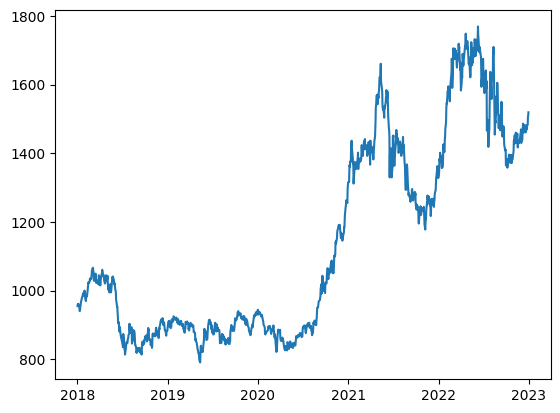

In [5]:
plt.plot(soybean_close_price)

Interpolate Missing dates in Price Data

In [6]:
soybean_close_price = soybean_close_price.asfreq(pd.infer_freq(soybean_close_price.index)) #interpolate missing dates
soybean_close_price = soybean_close_price.fillna(method='bfill')

Time range of country data are different

In [7]:
for i in weather_data:
    print(i + " " + str(len(weather_data[i])))

Argentina 1824
Brazil 1824
California 1826
Illinois 1826
Iowa 1826
Minnesota 1826
Nebraska 1826


In [8]:
for i in weather_data:
    start_date = str(weather_data[i].index[0])
    end_date = str(weather_data[i].index[-1])
    print(f"{i}: start {start_date}    end {end_date}" )

Argentina: start 2018-01-01 00:00:00    end 2022-12-31 00:00:00
Brazil: start 2018-01-01 00:00:00    end 2022-12-31 00:00:00
California: start 2018-01-01 00:00:00    end 2022-12-31 00:00:00
Illinois: start 2018-01-01 00:00:00    end 2022-12-31 00:00:00
Iowa: start 2018-01-01 00:00:00    end 2022-12-31 00:00:00
Minnesota: start 2018-01-01 00:00:00    end 2022-12-31 00:00:00
Nebraska: start 2018-01-01 00:00:00    end 2022-12-31 00:00:00


Weather Data Contains Gaps and last date differs from price data

In [9]:
for i in weather_data:
    weather_data[i] = weather_data[i]
    weather_data[i] = weather_data[i].asfreq(pd.infer_freq(weather_data[i].index)) #interpolate missing dates
    weather_data[i] = weather_data[i].fillna(method='bfill')
    weather_data[i] = weather_data[i][:-1] #remove last rows in weather data

soybean = df.asfreq(pd.infer_freq(df.index))
df = df.fillna(method='bfill')

In [10]:
for i in weather_data:
    start_date = str(weather_data[i].index[0])
    end_date = str(weather_data[i].index[-1])
    print(f"{i}: start {start_date}    end {end_date}" )

Argentina: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Brazil: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
California: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Illinois: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Iowa: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Minnesota: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Nebraska: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00


Concatenate weather data from different countries into a single dataframe

In [11]:
#Features
features = pd.DataFrame()
num_feature = 1 #total number of features, including close price and all weather data
for i in weather_data:
    weather_data[i].columns = list(map(lambda x: x+ "_" + i,  weather_data[i].columns))
    df = weather_data[i]
    features = pd.concat((features, df), axis=1)
    num_feature += len(weather_data[i].columns)

#features = pd.merge(soybean_price, features, left_index=True, right_index=True, how='inner') #Include close price as a feature


Normalization

In [12]:
def normalization(df):
    max = df.max()
    min = df.min()
    normalized_df = (df-min)/(max-min)
    return normalized_df, max, min

In [13]:
features, features_max, features_min  = normalization(features)
soybean_close_price, soybean_close_price_max, soybean_close_price_min = normalization(soybean_close_price)

In [16]:
soybean_close_price_max, soybean_close_price_min

(1769.0, 791.0)

STL Decomposition

In [17]:
price_stl = STL(soybean_close_price).fit() #perform STL decomposition on price
price_comp = [price_stl.trend, price_stl.seasonal, price_stl.resid]  #store components into price list
features_comp = [pd.merge(price_comp[i], features, left_index=True, right_index=True, how='inner') for i in range(3)] # generate features list where each element contains all weather features concatenated with associated component
#features_stl = features.apply(stl_decomp)

Text(0.5, 1.0, 'Residual')

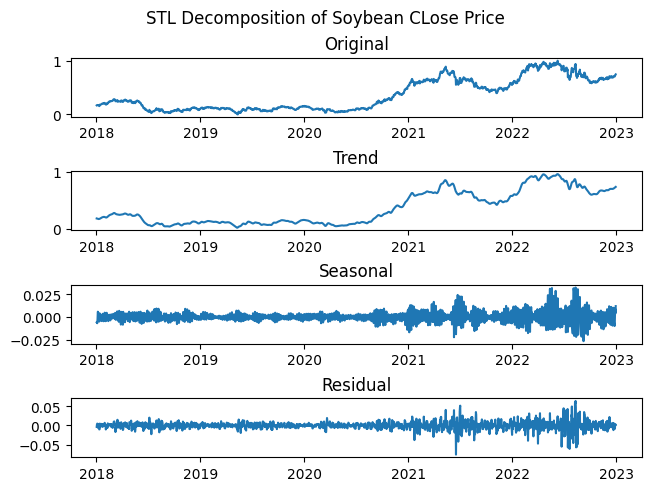

In [18]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,layout='constrained')
fig.suptitle('STL Decomposition of Soybean CLose Price')
ax0.plot(soybean_close_price)
ax0.set_title('Original')
ax1.plot(price_comp[0])
ax1.set_title('Trend')
ax2.plot(price_comp[1])
ax2.set_title('Seasonal')
ax3.plot(price_comp[2])
ax3.set_title('Residual')

Sample Data

In [19]:
def sampleData(features, price ,sampleLength):
  x = []
  y = []
  for i in range(len(price)-sampleLength-1):
    x += [features[i:i+sampleLength]]
    y += [price[i+sampleLength]]

  x = np.array(x)
  y = np.array(y)

  y = y[..., np.newaxis]
  
  return x, y

In [20]:
sampleLength = 30
x = [[],[],[]]
y = [[],[],[]]
for i in range(3):
    x[i], y[i] = sampleData(features_comp[i].to_numpy(), price_comp[i].to_numpy(),30)


Train Test Split

In [21]:
def train_test_split(x, y, split=0.2):
  trainLen = round(len(x)*(1-split))
  trainX, trainY, testX, testY = x[:trainLen], y[:trainLen], x[trainLen:], y[trainLen:]
  return trainX, trainY, testX, testY

In [22]:
trainX = [[],[],[]]
trainY = [[],[],[]]
testX = [[],[],[]]
testY = [[],[],[]]
for i in range(3):
    trainX[i], trainY[i], testX[i], testY[i] = train_test_split(x[i], y[i])

Model

In [23]:
def model():
    return Sequential([
      LSTM(128, input_shape=(sampleLength,num_feature), return_sequences = True),
      Dropout(0.2),
      LSTM(128),
      Dropout(0.2),
      Dense(16, activation="relu"),
      Dense(1, activation="linear")
    ])

In [24]:
#3 models for: Trend, Seasonal, Residual
trend_model = model()
seasonal_model = model()
residual_model = model()

Compile and Optimizer

In [25]:
def compile(model, lr=0.0001):
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mse"]
        )

In [26]:
compile(trend_model)
compile(seasonal_model)
compile(residual_model)

Fitting

In [27]:
def fit(model,trainX, trainY, testX, testY, epochs = 40, batch_size = 32):
    return model.fit(
            trainX, trainY,
            validation_data = (testX, testY),
            epochs = epochs,
            batch_size = batch_size)

In [28]:
history_trend = fit(trend_model, trainX[0], trainY[0], testX[0], testY[0])
history_seasonal = fit(seasonal_model, trainX[1], trainY[1], testX[1], testY[1])
history_residual = fit(residual_model, trainX[2], trainY[2], testX[2], testY[2])

Epoch 1/40
45/45 [==============================] - 5s 56ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/40
45/45 [==============================] - 2s 39ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 3/40
45/45 [==============================] - 2s 40ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/40
45/45 [==============================] - 2s 38ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 5/40
45/45 [==============================] - 2s 41ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/40
45/45 [==============================] - 2s 38ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 7/40
45/45 [==============================] - 2s 37ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 8/40
45/45 [==============================] - 2s 41ms/step - loss: 0.0011 - m

Text(0.5, 1.0, 'Residual')

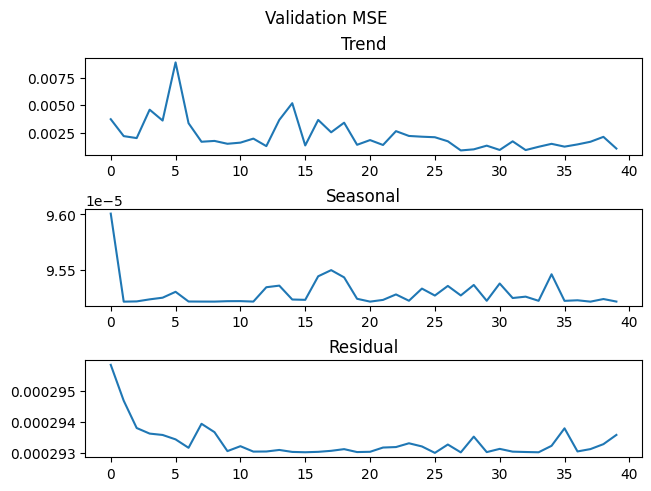

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3,layout='constrained')
fig.suptitle('Validation MSE')
ax1.plot(history_trend.history["val_mse"])
ax1.set_title('Trend')
ax2.plot(history_seasonal.history["val_mse"])
ax2.set_title('Seasonal')
ax3.plot(history_residual.history["val_mse"])
ax3.set_title('Residual')

Predict

In [30]:
def predict(features):
    pred_trend = trend_model.predict(features[0])
    pred_seasonal = seasonal_model.predict(features[1])
    pred_residual = residual_model.predict(features[2])
    return pred_trend + pred_seasonal + pred_residual

In [31]:
prediction = predict((x[0], x[1], x[2]))

57/57 [==============================] - 1s 13ms/step


In [32]:
def unnormalize(arr, min, max):
    unormalized_arr = arr*(max-min) + min
    return unormalized_arr

In [33]:
prediction = unnormalize(prediction, soybean_close_price_min, soybean_close_price_max)
soybean_close_price = unnormalize(soybean_close_price.to_numpy(), soybean_close_price_min, soybean_close_price_max)

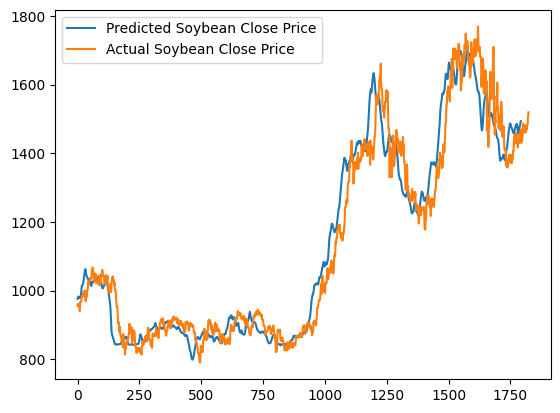

In [35]:
plt.plot(prediction, label = 'Predicted Soybean Close Price')
plt.plot(soybean_close_price, label = 'Actual Soybean Close Price')
plt.legend()